# Piecewise classification

Piecewise regression is easier to understand but the concept can be extended to classification. That's what this notebook explores.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Iris dataset and first logistic regression

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, Y)

c:\python370_x64\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python370_x64\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


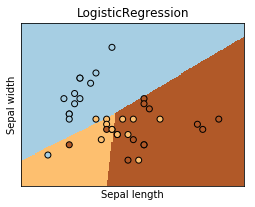

In [4]:
import numpy
import matplotlib.pyplot as plt

def graph(X, Y, model):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                            numpy.arange(y_min, y_max, h))
    Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Put the result into a color plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
ax = graph(X_test, y_test, logreg)
ax.set_title("LogisticRegression");

## Piecewise classication



In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import KBinsDiscretizer
from mlinsights.mlmodel import PiecewiseClassifier
piece4 = PiecewiseClassifier(KBinsDiscretizer(n_bins=2),
                            estimator=DummyClassifier('most_frequent'), verbose=True)
piece4.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


PiecewiseClassifier(binner=KBinsDiscretizer(encode='onehot', n_bins=2, strategy='quantile'),
          estimator=DummyClassifier(constant=None, random_state=None, strategy='most_frequent'),
          n_jobs=None, random_state=None, verbose=True)

We look into the bucket given to each point.

In [6]:
import pandas

bucket = piece4.transform_bins(X_test)
df = pandas.DataFrame(X_test, columns=("x1", "x2"))
df["bucket"] = bucket
df["label"] = y_test
df = df.set_index(bucket)
df.head(n=5)

,x1,x2,bucket,label
2.0,5.0,3.5,2.0,0
1.0,5.8,2.7,1.0,2
2.0,5.1,3.8,2.0,0
2.0,5.6,3.0,2.0,1
1.0,5.8,2.7,1.0,1


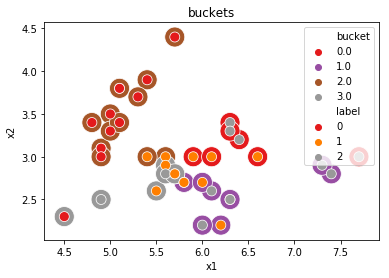

In [7]:
import seaborn
ax = seaborn.scatterplot("x1", "x2", "bucket", data=df, palette='Set1', s=400)
seaborn.scatterplot("x1", "x2", "label", data=df, palette='Set1', marker="o", ax=ax, s=100)
ax.set_title("buckets");

We see there are four buckets. Two buckets only contains one label. The dummy classifier maps every bucket to the most frequent class in the bucket.

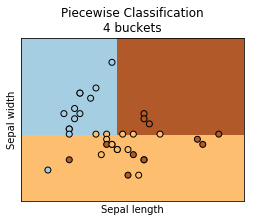

In [8]:
ax = graph(X_test, y_test, piece4)
ax.set_title("Piecewise Classification\n4 buckets");

We can increase the number of buckets.

In [9]:
piece9 = PiecewiseClassifier(KBinsDiscretizer(n_bins=3),
                            estimator=DummyClassifier('most_frequent'), verbose=True)
piece9.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


PiecewiseClassifier(binner=KBinsDiscretizer(encode='onehot', n_bins=3, strategy='quantile'),
          estimator=DummyClassifier(constant=None, random_state=None, strategy='most_frequent'),
          n_jobs=None, random_state=None, verbose=True)

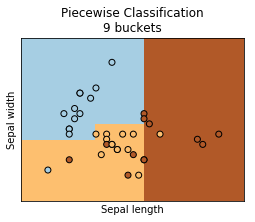

In [10]:
ax = graph(X_test, y_test, piece9)
ax.set_title("Piecewise Classification\n9 buckets");

Let's compute the ROC curve.

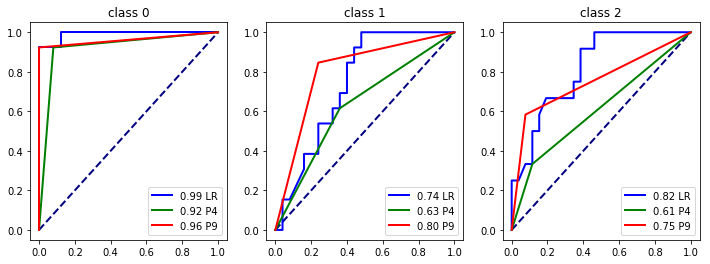

In [11]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models, X, y):
    if not isinstance(models, dict):
        return plot_roc_curve({models.__class__.__name__: models}, X, y)

    ax = None
    colors = 'bgrcmyk'    
    for ic, (name, model) in enumerate(models.items()):
        fpr, tpr, roc_auc = dict(), dict(), dict()
        nb = len(model.classes_)
        y_score = model.predict_proba(X)
        for i in range(nb):
            c = model.classes_[i]
            fpr[i], tpr[i], _ = roc_curve(y_test == c, y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        if ax is None:
            lw = 2
            _, ax = plt.subplots(1, nb, figsize=(4 * nb, 4))
            for i in range(nb):
                ax[i].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plotname = "".join(c for c in name if "A" <= c <= "Z" or "0" <= c <= "9")
        for i in range(nb):
            ax[i].plot(fpr[i], tpr[i], color=colors[ic],
                       lw=lw, label='%0.2f %s' % (roc_auc[i], plotname))
            ax[i].set_title("class {}".format(model.classes_[i]))
    for k in range(ax.shape[0]):
        ax[k].legend()
    return ax
                           
plot_roc_curve({'LR': logreg, 'P4': piece4, 'P9': piece9}, X_test, y_test);

Let's use the decision tree to create buckets.

In [12]:
pieceT = PiecewiseClassifier("tree",
                             estimator=DummyClassifier('most_frequent'), verbose=True)
pieceT.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished


PiecewiseClassifier(binner=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          estimator=DummyClassifier(constant=None, random_state=None, strategy='most_frequent'),
          n_jobs=None, random_state=None, verbose=True)

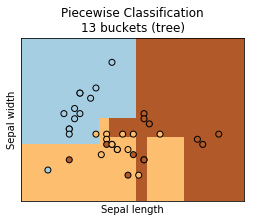

In [13]:
ax = graph(X_test, y_test, pieceT)
ax.set_title("Piecewise Classification\n%d buckets (tree)" % len(pieceT.estimators_));

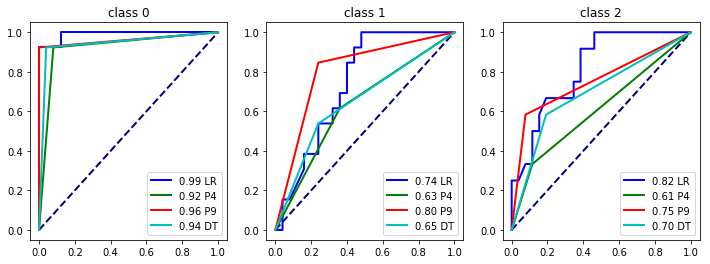

In [14]:
plot_roc_curve({'LR': logreg, 'P4': piece4, 'P9': piece9, "DT": pieceT},
               X_test, y_test);